In [342]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import random
%matplotlib inline

In [343]:
args = {'lr':0.01,
        'train epochs':20000,
        'hidden layers':2,
        'noise':0.001,
        'train size':0.7,
        'spec scale':10**12,
        'start size':30,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler()
        }

In [344]:
df = pd.read_excel('data_3nm.xlsx')

In [345]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [346]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [347]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [348]:
# add noise
X_noisy = add_noise(X, args['noise'])

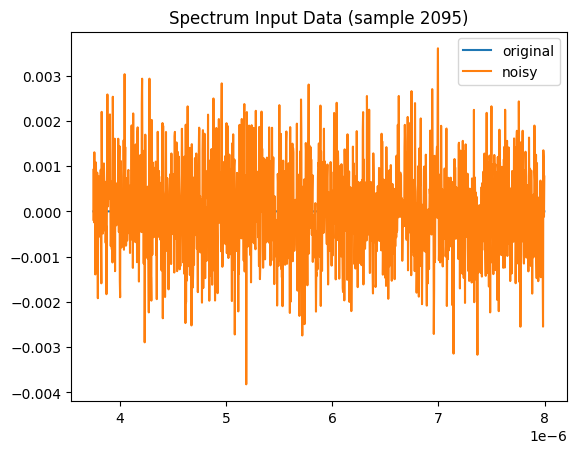

In [349]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [350]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [351]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=101)

In [352]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [353]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(Net, self).__init__()
        
        start_size = args['start size']
        hidden_sizes = [input_size]
        step = start_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(start_size - (i+1) * step)
            if hidden_size < 11: hidden_size = 11
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.lin_fin(x)
        return x

In [354]:
criterion = args['train criterion']
model = Net(X_train_tensor.size()[1], y_train_tensor.size()[1], args['hidden layers'])
optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

print(model)

Net(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1417, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=11, bias=True)
  )
  (lin_fin): Linear(in_features=11, out_features=11, bias=True)
)


In [355]:
best_loss = np.inf
best_epoch = 0
train_losses = []

for epoch in range(args['train epochs']):
    # forward pass
    outputs = model(X_train_tensor)

    # get loss
    loss = criterion(outputs, y_train_tensor)

    # update and backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch+1

    if (epoch+1) % int(args['train epochs']/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss:.3f}')

print(f'best loss: {best_loss:.3f} in epoch {best_epoch}\n')  

epoch: 2000, loss = 10.951
epoch: 4000, loss = 10.943
epoch: 6000, loss = 10.937


KeyboardInterrupt: 

In [ ]:
test_criterion = args['test criterion']
with torch.no_grad():
    pred = model(X_test_tensor)
    loss = test_criterion(pred, y_test_tensor)

    print(loss.item())

3.2286136150360107


In [ ]:
pred_df = pd.DataFrame(pred.numpy())

In [ ]:
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

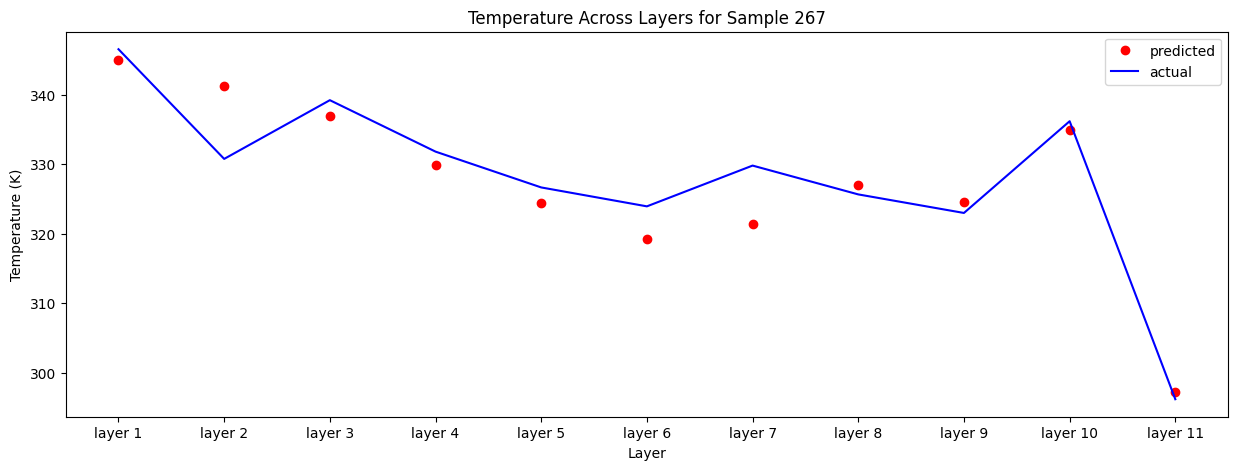

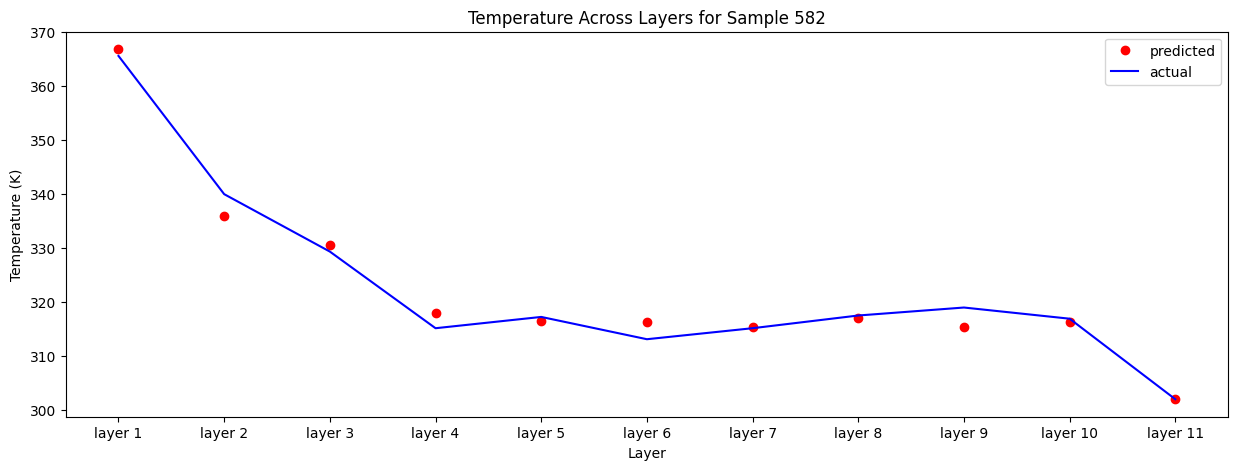

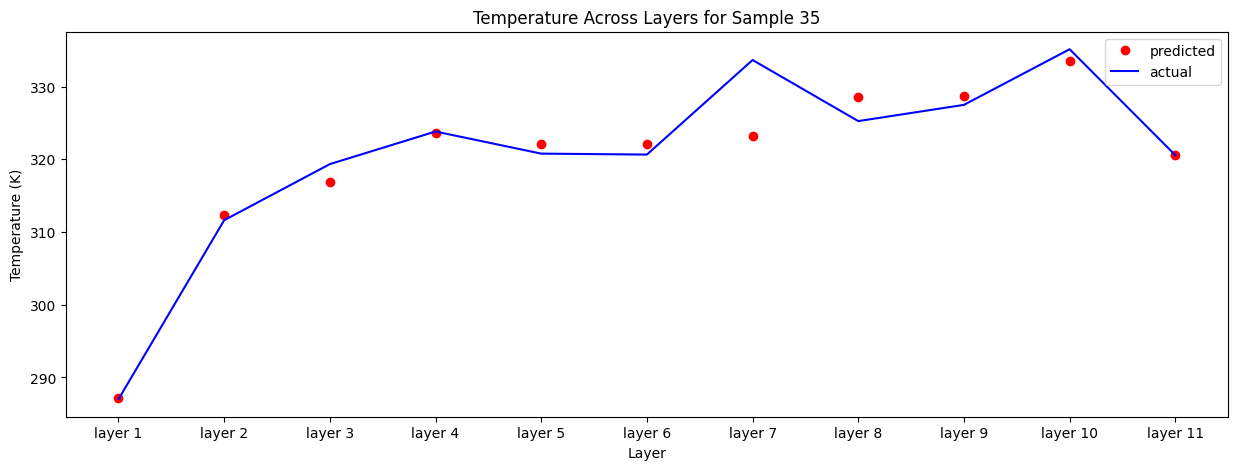

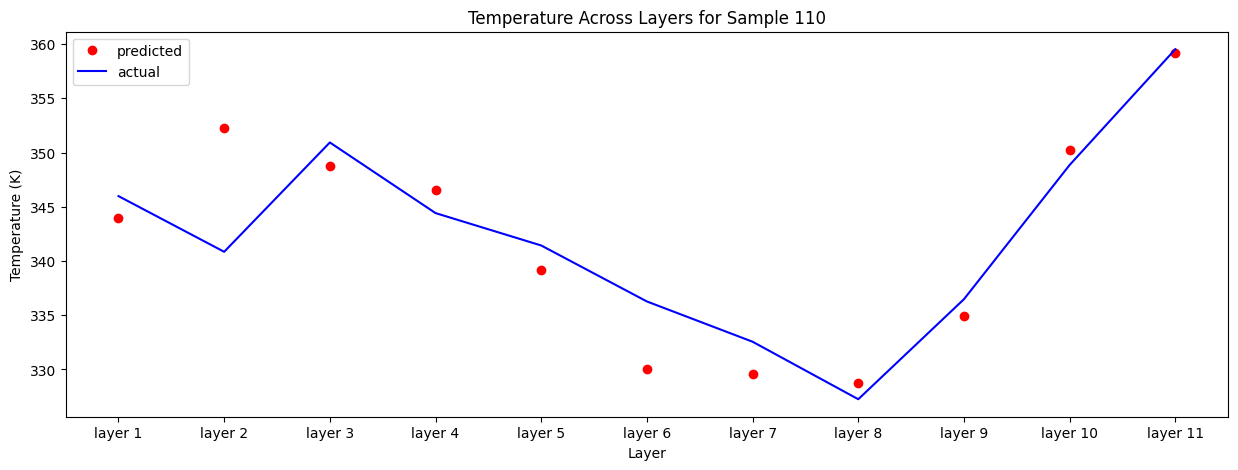

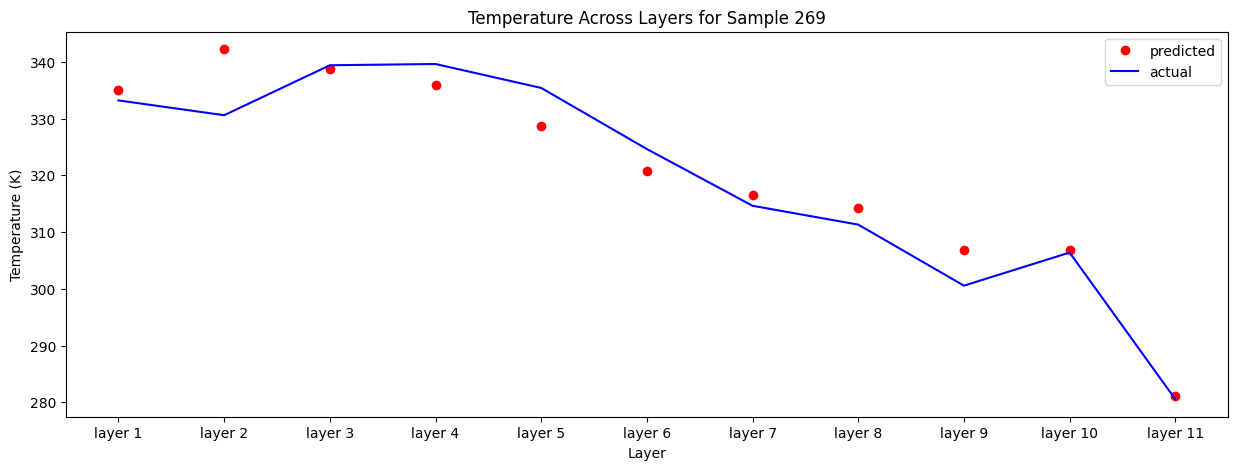

In [ ]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    a = y_test.iloc[i,:]
    p = pred_df.iloc[i,:]

    plot_comparison(p, a, i)